In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive/')
sys.path.append('/content/drive/MyDrive/TradeCosts')

Mounted at /content/drive/


In [ ]:
import Data_generator_multiple as dg
import Portfolio_info as poi
import datetime
import sys
import pandas as pd
import scipy.stats as stats
from datetime import date
import numpy as np
import yfinance as yf
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.cuda.amp import autocast, GradScaler
from torch import optim
import Func_More_Assets as FMA
import Func_Two_Assets as FTA
from mpl_toolkits.mplot3d import Axes3D
import Plot_More_Assets as PMA
import matplotlib.pyplot as plt
from matplotlib import animation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# Set model parameters
seed_train = 36
seed_test = 44
num_stocks = 2
total_path = 20000
n_partition = 1
npaths = int(total_path/n_partition)
seq_length = 120
T=10
s0=np.array([1,1])
mu = np.array([0.12, 0.12])
#mu = np.array([0.0362, 0.0036])
k = 0.15
#cov = np.array([[0.0225, 0.00132],[0.00132, 0.0016]])
cov = np.array([[0.4-k, k],[k, 0.4-k]])
trade_cost = np.array([[0.01,0.01]])
utility_gamma = 2.000

# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 80
learning_rate = 0.01
is_importance = True
is_batch = False

In [ ]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# Set model parameters
seed_train = 36
seed_test = 47
num_stocks = 2
total_path = 26000
seq_length = 120
T=10
n_partition = 1
npaths = int(total_path/n_partition)
s0=np.array([1,1])
#mu = np.array([0.12, 0.12])
mu = np.array([0.0362, 0.0036])
#k = 0.075
#cov = np.array([[0.4-k, k],[k, 0.4-k]])
cov = np.array([[0.0225, 0.00132],[0.00132, 0.0016]])
trade_cost = np.array([[0.0001,0.0025],[0.0001,0.005],[0.0001,0.01],[0.0001,0.025],[0.0001,0.05]])
#trade_cost = np.array([[0.0001,0.0005]])
utility_gamma = 3.000

# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 60
learning_rate = 0.01
initial_rotate_matrix = torch.tensor([[1.05,-0.05], [-0.05,1.05]])
is_importance = False
is_batch = False

In [ ]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# Set model parameters
seed_train = 36
seed_test = 43
num_stocks = 2
total_path = 25000
seq_length = 120
T=10
n_partition = 1
npaths = int(total_path/n_partition)
s0=np.array([1,1])
#mu = np.array([0.12, 0.12])
mu = np.array([0.0362, 0.0036])
#k = 0.075
#cov = np.array([[0.4-k, k],[k, 0.4-k]])
cov = np.array([[0.0225, 0.00132],[0.00132, 0.0016]])
trade_cost = np.array([[0.0001,0.0025],[0.0001,0.005],[0.0001,0.01],[0.0001,0.025],[0.0001,0.05]])
utility_gamma = 3.000

# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 60
learning_rate = 0.01
initial_rotate_matrix = torch.tensor([[1.05,-0.05], [-0.05,1.05]])
is_importance = False
is_batch = False

In [ ]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# Set model parameters
seed_train = 36
seed_test = 44
num_stocks = 3
total_path = 30000
n_partition = 1
npaths = int(total_path/n_partition)
seq_length = 80
T=5
s0=np.array([1,1,1])
mu = np.array([0.12, 0.12, 0.12])
cov = 0.032*np.ones([3,3])
np.fill_diagonal(cov,0.16)
trade_cost = np.array([[0.01,0.01,0.01]])
utility_gamma = 4

# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 100
learning_rate = 0.005
is_importance = True
is_batch = False

In [ ]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()
# info of the specific portfolio ETF
manage_fee = 0.0027
etf = 'EQL'
tickers = ["XLE", "XLF", "XLP", "XLV", "XLB", "XLK", "XLY", "XLI", "XLU", "XLRE", "XLC"]
#tickers = ["XLE", "XLF", "XLP", "XLV", "XLB", "XLK", "XLY", "XLI", "XLU"]
#set up dates
#start = '2019-02-28'
#end = '2023-05-31'
start = '1998-08-01'
end = '2023-06-01'
start_day,end_day = str(start).split('-'),str(end).split('-')
# create portfolio
utility_gamma = 4
my_portfolio = poi.EqualWeight(etf, tickers, utility_gamma,manage_fee, start , end)
# Set model parameters
T = 10
seed_train = 36
seed_test = 44
num_stocks = len(tickers)
total_path = 20000
n_partition = 1
npaths = int(total_path/n_partition)
seq_length = int(T*12)
s0=np.array([1]*num_stocks)

cov = FMA.return_matrix_modification(my_portfolio.covariance(), num_stocks)
mu = (utility_gamma*np.matmul(cov,my_portfolio.strategy()))
mu = np.array(mu.T.tolist()[0])
trade_cost = np.array([[0.01]*num_stocks])

# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 90
learning_rate = 0.008
is_importance = True
is_batch = False

In [ ]:
ESR_RNN_vec = np.zeros((trade_cost.shape[0]))
CI_upper_vec = np.zeros((trade_cost.shape[0]))
CI_lower_vec = np.zeros((trade_cost.shape[0]))
ESR_theo_vec = np.zeros((trade_cost.shape[0]))
ESR_opt_vec = np.zeros((trade_cost.shape[0]))

/content/drive/MyDrive/TradeCosts/Func_Two_Assets.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delta_tensor = torch.tensor(delta, dtype = torch.float).to(device)
/content/drive/MyDrive/TradeCosts/NN_More_Assets.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pi_bar = (torch.tensor(target,dtype=torch.float).to(device).view(self.dim_size,self.hidden_size,self.hidden_size)*\


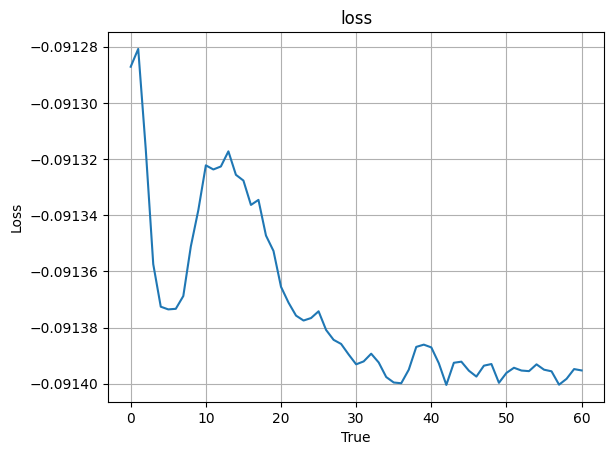

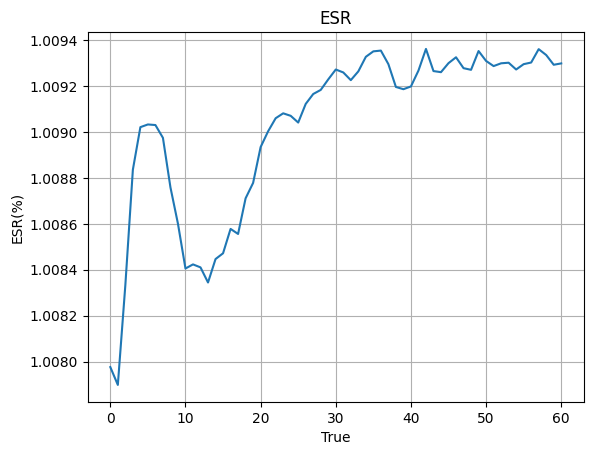

/content/drive/MyDrive/TradeCosts/Func_Two_Assets.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delta_tensor = torch.tensor(delta, dtype = torch.float).to(device)


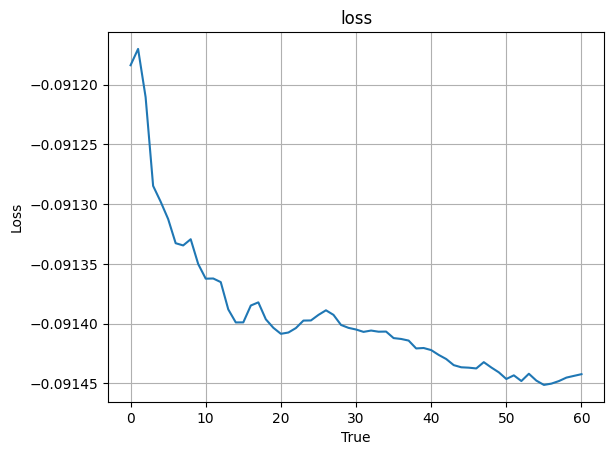

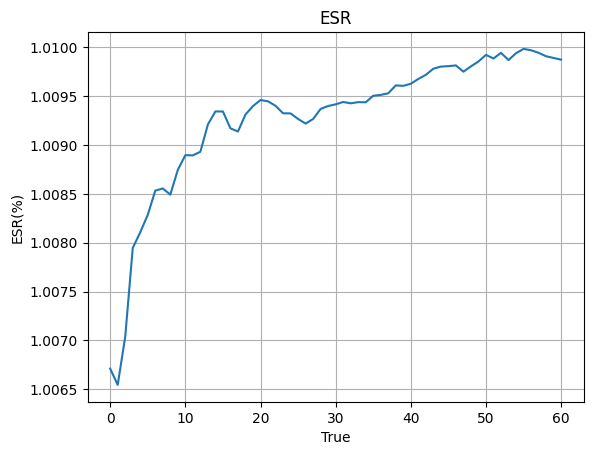

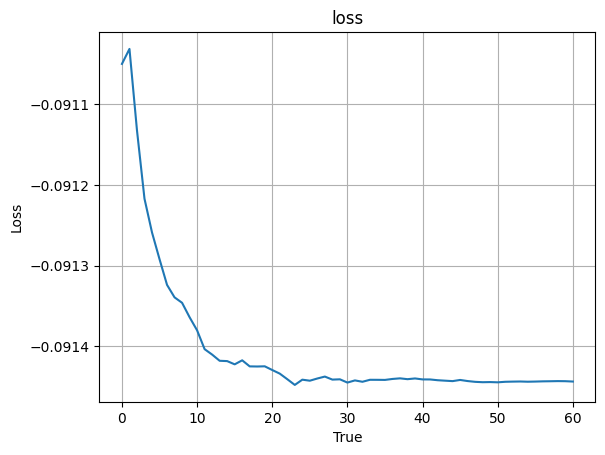

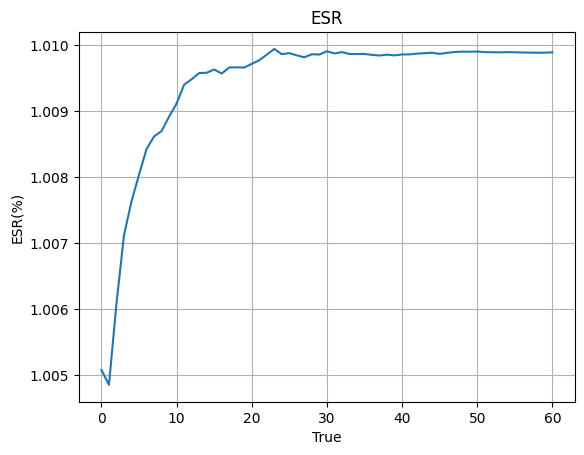

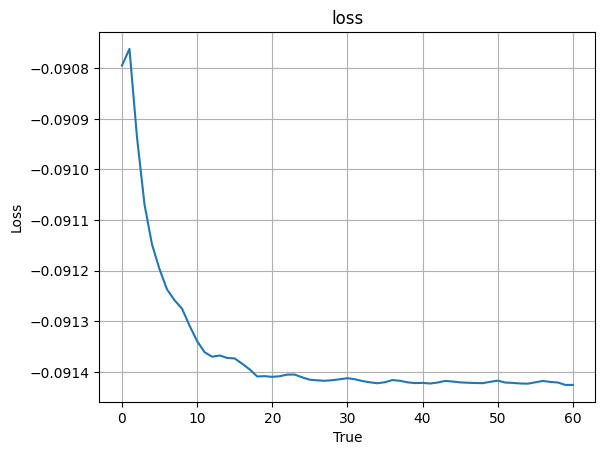

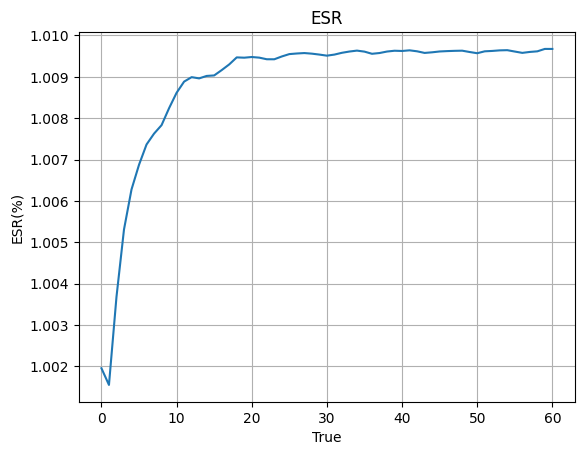

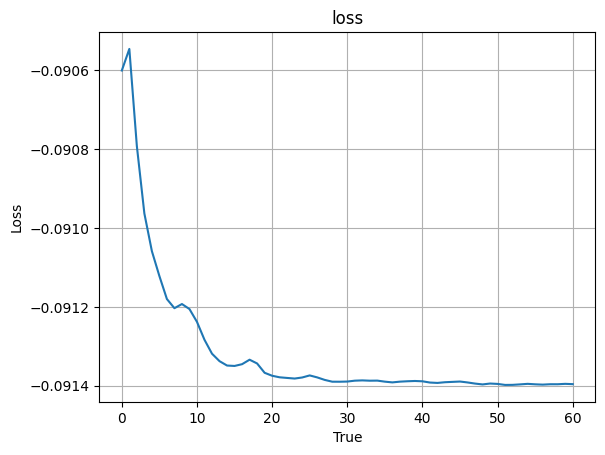

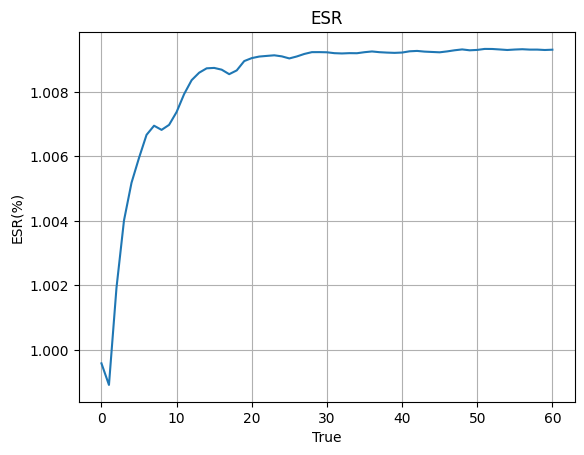

In [ ]:
for i in range(trade_cost.shape[0]):
    #set up training data and model
    returns, strategy, cost, Merton_opt, Merton_opt_tensor, delta_tensor = FTA.make_portfolio\
        (i,seed_train,mu,cov,s0,total_path,num_stocks,seq_length,T,trade_cost,utility_gamma)
    returns, scaler = FTA.importance_sampling\
        (is_importance,seed_train,mu,cov,s0,num_stocks, total_path,seq_length,utility_gamma,T)
    model, criterion, optimizer = FMA.make_model\
        (1, 1, 1, num_stocks, npaths, seq_length, delta_tensor, utility_gamma, learning_rate)
    model,losses = FMA.train_model\
        (strategy, strategy[:,0,0], returns, cost, scaler, model, criterion, optimizer,n_epochs,is_batch,n_partition,npaths,utility_gamma,T)
    model_state_dict = model.state_dict()
    # set up testing data
    returns, strategy, cost, Merton_opt, Merton_opt_tensor, delta_tensor = FTA.make_portfolio\
        (i,seed_test,mu,cov,s0,total_path,num_stocks,seq_length,T,trade_cost,utility_gamma)

    # theoretical ESR without cost
    ESR_opt = np.matmul(mu.T,np.matmul(np.linalg.inv(cov),mu))/2/utility_gamma
    # ESRs with costs
    ESR_etf, ESR_NTR, ESR_RNN, CI = FMA.ESR\
        (1, 1, 1,num_stocks, seq_length, npaths,model_state_dict,  strategy, returns, cost, utility_gamma, T, scaler = 1)
    ESR_special = FTA.ESR_special(mu,cov,utility_gamma,trade_cost[i])
    ESR_RNN_vec[i] = ESR_RNN[0]
    CI_upper_vec[i] = CI[0]
    CI_lower_vec[i] = CI[1]
    ESR_theo_vec[i] = ESR_special
    ESR_opt_vec[i] = ESR_opt

    #delete used data
    del optimizer
    del returns
    torch.cuda.empty_cache()
    if i != trade_cost.shape[0]-1:
        del model

/content/drive/MyDrive/TradeCosts/Plot_More_Assets.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  Cmean, = ax.plot(x, simulated, 'k--',color='blue')


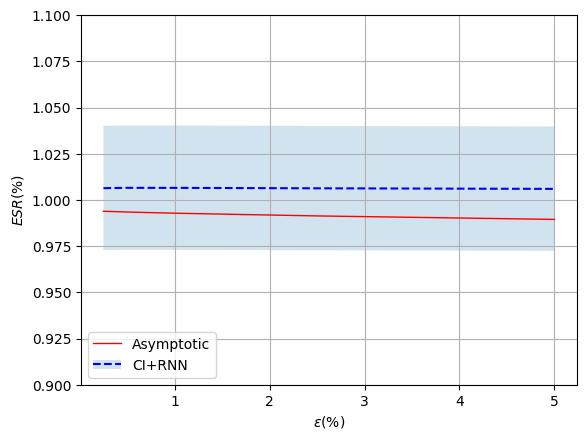

In [ ]:
PMA.plot_esr(np.array(trade_cost[:,1]),ESR_theo_vec,CI_lower_vec,CI_upper_vec,ESR_RNN_vec)